# Testing Navier-Stokes with a body in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past a stationary body

Set the flow parameters

In [3]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set up points on the body

In [4]:
n = 51;
a = 0.5; b = 0.1;
body = Bodies.Plate(1.0,n)

Plate with 51 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Set the body motion. Make it stationary.

In [5]:
motion = RigidBodyMotion(0.0,0.0)

Rigid Body Motion:
  ċ = 0.0 + 0.0im
  c̈ = 0.0 + 0.0im
  α̇ = 0.0
  α̈ = 0.0
  Constant (ċ = 0.0 + 0.0im, α̇ = 0.0)

Transform the body with a specified initial position and orientation.

In [6]:
cent = 1.0+1.0im
α = -π/4
_,ċ,_,_,α̇,_ = motion(0.0)  # Additional 
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration
ds = Bodies.dlength(body); # we will need the arc lengths of each face on the body for later

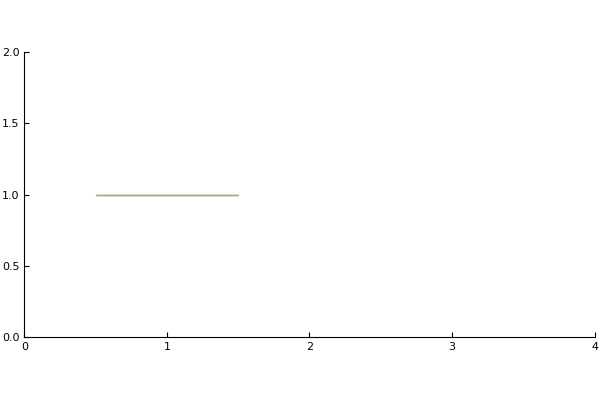

In [7]:
plot(body,xlim=(0,4),ylim=(0,2))

Now set up the coordinate data for operator construction

In [8]:
X = VectorData(body.x,body.y);
X̃ = VectorData(body.x̃,body.ỹ);

Set the domain size and time step size

In [9]:
nx = 202; ny = 102;
Ly = 2.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re);
w₀ = Nodes(Dual,(nx,ny));
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:4.01, -0.01:0.02:2.0100000000000002)

### Now start constructing operators

#### Set up the state vector and constraint force vector for a static body

In [10]:
u = w₀
f = VectorData(X̃);
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 202 x 102

In [11]:
ifherk = IFHERK(u,f,sys.Δt,
                (t,u) -> Systems.plan_intfact(t,u,sys),
                (u,t) -> TimeMarching.plan_constraints(u,t,sys),
                ((u,t) -> Systems.r₁(u,t,sys),
                 (u,t) -> Systems.r₂(u,t,sys)),rk=TimeMarching.RK31,isstored=true)

Order-3 IF-HERK integrator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,202,102}
   Force of type Whirl.Fields.VectorData{51}
   Time step size 0.01


In [12]:
t = 0.0
w₀ .= 0.0
u = deepcopy(w₀)
tf = 4.0;
T = 0:Δt:tf;
fx = Float64[];
fy = Float64[];
thist = Float64[];

In [13]:
@time for ti in T
    t, u, f = ifherk(t,u)
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
end
println("solution completed through time t = ",t)

 29.390790 seconds (5.46 M allocations: 3.913 GiB, 2.63% gc time)
solution completed through time t = 4.009999999999959


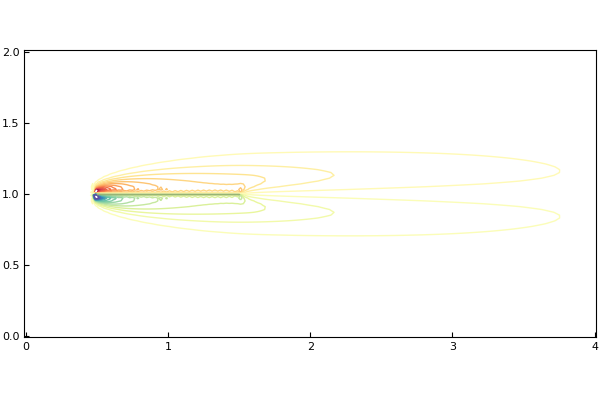

/Users/jeff/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)


In [14]:
plot(xg,yg,u,levels=linspace(-0.5,0.5,30))
plot!(body)

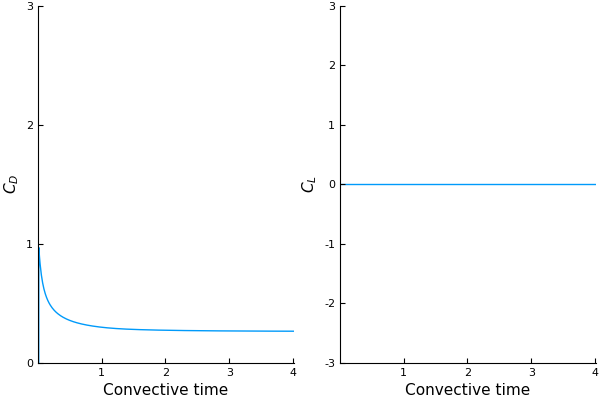

In [16]:
px = plot(thist,2*fx,ylim=(0,3),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(-3,3),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

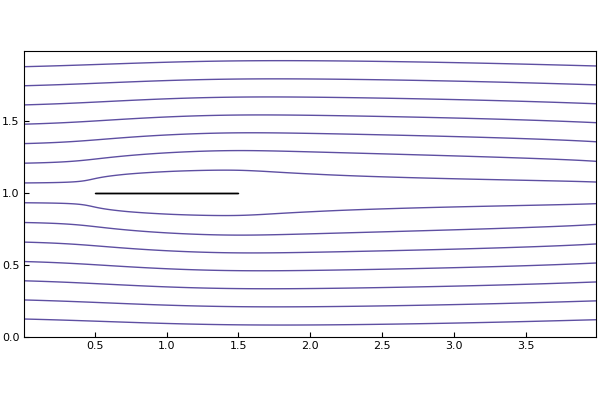

In [19]:
xg,yg = coordinates(u,dx=Δx)
ψ = deepcopy(u)
ψ .= -(sys.L\u)*Δx .+ repmat(collect(yg)',202,1)
plot(xg,yg,ψ,trim=1,clim=(-0.1,0.1))
plot!(body,fillcolor=:black,linecolor=:black)

In [5]:
regopfilter = Regularize(X,Δx;weights=ds,filter=true)
H̃mat = RegularizationMatrix(regopfilter,f,q);
Ẽmat = InterpolationMatrix(regopfilter,q,f);
P(f::VectorData) = Ẽmat*(H̃mat*f)